## 초기설정

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

ValueError: mount failed

In [ ]:
!pip uninstall tensorflow -y
!pip install tensorflow_io[tensorflow]

In [ ]:
!pip install keras_cv

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 650.7/650.7 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 14.1 MB/s eta 0:00:00


In [ ]:
import os
os.environ["KERAS_BACKEND"] = "jax"  # "jax" or "tensorflow" or "torch"

import numpy as np
import pandas as pd
import math

from glob import glob
from tqdm import tqdm

import joblib # Used for exporting and importing trained models
import librosa # Used for processing audio

# Visualization libraries
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import IPython.display as ipd
from IPython.display import Audio # Used for displaying an interactive audio player
import librosa.display as lid

# Machine learning libraries
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import RandomOverSampler
import keras_cv
import keras
import keras.backend as K
import tensorflow as tf
import tensorflow_io as tfio

cmap = mpl.cm.get_cmap('coolwarm')

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

<ipython-input-4-40172367abc6>:34: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.get_cmap('coolwarm')


In [ ]:
# !mkdir -p ~/.kaggle
# !cp kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json

# !kaggle competitions download  birdclef-2024 -f train_metadata.csv
# !kaggle competitions download  birdclef-2024 -f eBird_Taxonomy_v2021.csv

# !unzip train_metadata.csv.zip
# !unzip eBird_Taxonomy_v2021.csv.zip

In [ ]:
class CFG:
    seed = 42

    # Input image size and batch size
    img_size = [128, 384]
    batch_size = 64

    # Audio duration, sample rate, and length
    duration = 15 # second
    sample_rate = 32000
    audio_len = duration*sample_rate

    # STFT parameters
    nfft = 2028
    window = 2048
    hop_length = audio_len // (img_size[1] - 1)
    fmin = 20
    fmax = 16000

    # Number of epochs, model name
    epochs = 20
    preset = 'efficientnetv2_b2_imagenet'

    # Data augmentation parameters
    augment=True

    num_classes = 182

    # Class Labels for BirdCLEF 24
    class_names = ['asbfly','ashdro1','ashpri1','ashwoo2','asikoe2','asiope1','aspfly1','aspswi1','barfly1','barswa','bcnher','bkcbul1','bkrfla1','bkskit1','bkwsti',
                   'bladro1','blaeag1','blakit1','blhori1','blnmon1','blrwar1','bncwoo3','brakit1','brasta1','brcful1','brfowl1','brnhao1','brnshr','brodro1','brwjac1',
                   'brwowl1','btbeat1','bwfshr1','categr','chbeat1','cohcuc1','comfla1','comgre','comior1','comkin1','commoo3','commyn','compea','comros','comsan','comtai1',
                   'copbar1','crbsun2','cregos1','crfbar1','crseag1','dafbab1','darter2','eaywag1','emedov2','eucdov','eurbla2','eurcoo','forwag1','gargan','gloibi','goflea1',
                   'graher1','grbeat1','grecou1','greegr','grefla1','grehor1','grejun2','grenig1','grewar3','grnsan','grnwar1','grtdro1','gryfra','grynig2','grywag','gybpri1',
                   'gyhcaf1','heswoo1','hoopoe','houcro1','houspa','inbrob1','indpit1','indrob1','indrol2','indtit1','ingori1','inpher1','insbab1','insowl1','integr','isbduc1',
                   'jerbus2','junbab2','junmyn1','junowl1','kenplo1','kerlau2','labcro1','laudov1','lblwar1','lesyel1','lewduc1','lirplo','litegr','litgre1','litspi1','litswi1',
                   'lobsun2','maghor2','malpar1','maltro1','malwoo1','marsan','mawthr1','moipig1','nilfly2','niwpig1','nutman','orihob2','oripip1','pabflo1','paisto1','piebus1',
                   'piekin1','placuc3','plaflo1','plapri1','plhpar1','pomgrp2','purher1','pursun3','pursun4','purswa3','putbab1','redspu1','rerswa1','revbul','rewbul','rewlap1',
                   'rocpig','rorpar','rossta2','rufbab3','ruftre2','rufwoo2','rutfly6','sbeowl1','scamin3','shikra1','smamin1','sohmyn1','spepic1','spodov','spoowl1','sqtbul1',
                   'stbkin1','sttwoo1','thbwar1','tibfly3','tilwar1','vefnut1','vehpar1','wbbfly1','wemhar1','whbbul2','whbsho3','whbtre1','whbwag1','whbwat1','whbwoo2','whcbar1',
                   'whiter2','whrmun','whtkin2','woosan','wynlau1','yebbab1','yebbul3','zitcis1']  # train_audio내의 전체 폴더명
    num_classes = len(class_names)
    class_labels = list(range(num_classes))
    label2name = dict(zip(class_labels, class_names))
    name2label = {v:k for k,v in label2name.items()}

In [ ]:
tf.keras.utils.set_random_seed(CFG.seed)

In [ ]:
BASE_PATH = '/content/drive/MyDrive/Colab Notebooks/AI를 위한 딥러닝/프로젝트/birdclef-2024'

## 데이터 로드

### train_metadata

In [ ]:
train_meta = pd.read_csv(f'{BASE_PATH}/train_metadata.csv')
train_meta['filepath'] = BASE_PATH + '/train_audio/' + train_meta.filename
train_meta['target'] = train_meta.primary_label.map(CFG.name2label)
train_meta['filename'] = train_meta.filepath.map(lambda x: x.split('/')[-1])
train_meta['xc_id'] = train_meta.filepath.map(lambda x: x.split('/')[-1].split('.')[0])

# Display rows
train_meta.head(2)

,primary_label,secondary_labels,type,latitude,longitude,scientific_name,common_name,author,license,rating,url,filename,filepath,target,xc_id
0,asbfly,[],['call'],39.2297,118.1987,Muscicapa dauurica,Asian Brown Flycatcher,Matt Slaymaker,Creative Commons Attribution-NonCommercial-Sha...,5.0,https://www.xeno-canto.org/134896,XC134896.ogg,/content/drive/MyDrive/Colab Notebooks/AI를 위한 ...,0,XC134896
1,asbfly,[],['song'],51.4030,104.6401,Muscicapa dauurica,Asian Brown Flycatcher,Magnus Hellström,Creative Commons Attribution-NonCommercial-Sha...,2.5,https://www.xeno-canto.org/164848,XC164848.ogg,/content/drive/MyDrive/Colab Notebooks/AI를 위한 ...,0,XC164848


In [ ]:
def summary(df):
    summry = pd.DataFrame(df.dtypes, columns=['data type'])
    summry['#missing'] = df.isnull().sum().values
    summry['Duplicate'] = df.duplicated().sum()
    summry['#unique'] = df.nunique().values
    desc = pd.DataFrame(df.describe(include='all').transpose())
    summry['min'] = desc['min'].values
    summry['max'] = desc['max'].values
    summry['avg'] = desc['mean'].values
    summry['std dev'] = desc['std'].values
    summry['top value'] = desc['top'].values
    summry['Freq'] = desc['freq'].values

    return summry

In [ ]:
summary(train_meta).style.set_caption("**Summary of the Train Data**").\
background_gradient(cmap='Pastel2_r', axis=0). \
set_properties(**{'border': '1.3px dotted', 'color': '', 'caption-side': 'left'})

,data type,#missing,Duplicate,#unique,min,max,avg,std dev,top value,Freq
primary_label,object,0,0,182,nan,nan,nan,nan,hoopoe,500
secondary_labels,object,0,0,491,nan,nan,nan,nan,[],22567
type,object,0,0,918,nan,nan,nan,nan,[''],6188
latitude,float64,378,0,9098,-43.524000,71.964000,32.537040,19.440382,nan,nan
longitude,float64,378,0,9182,-171.765400,177.447800,43.640699,50.191352,nan,nan
scientific_name,object,0,0,182,nan,nan,nan,nan,Upupa epops,500
common_name,object,0,0,182,nan,nan,nan,nan,Eurasian Hoopoe,500
author,object,0,0,1942,nan,nan,nan,nan,José Carlos Sires,915
license,object,0,0,4,nan,nan,nan,nan,Creative Commons Attribution-NonCommercial-ShareAlike 4.0,22344
rating,float64,0,0,11,0.000000,5.000000,3.843493,1.100840,nan,nan


Total unique bird species:  182 



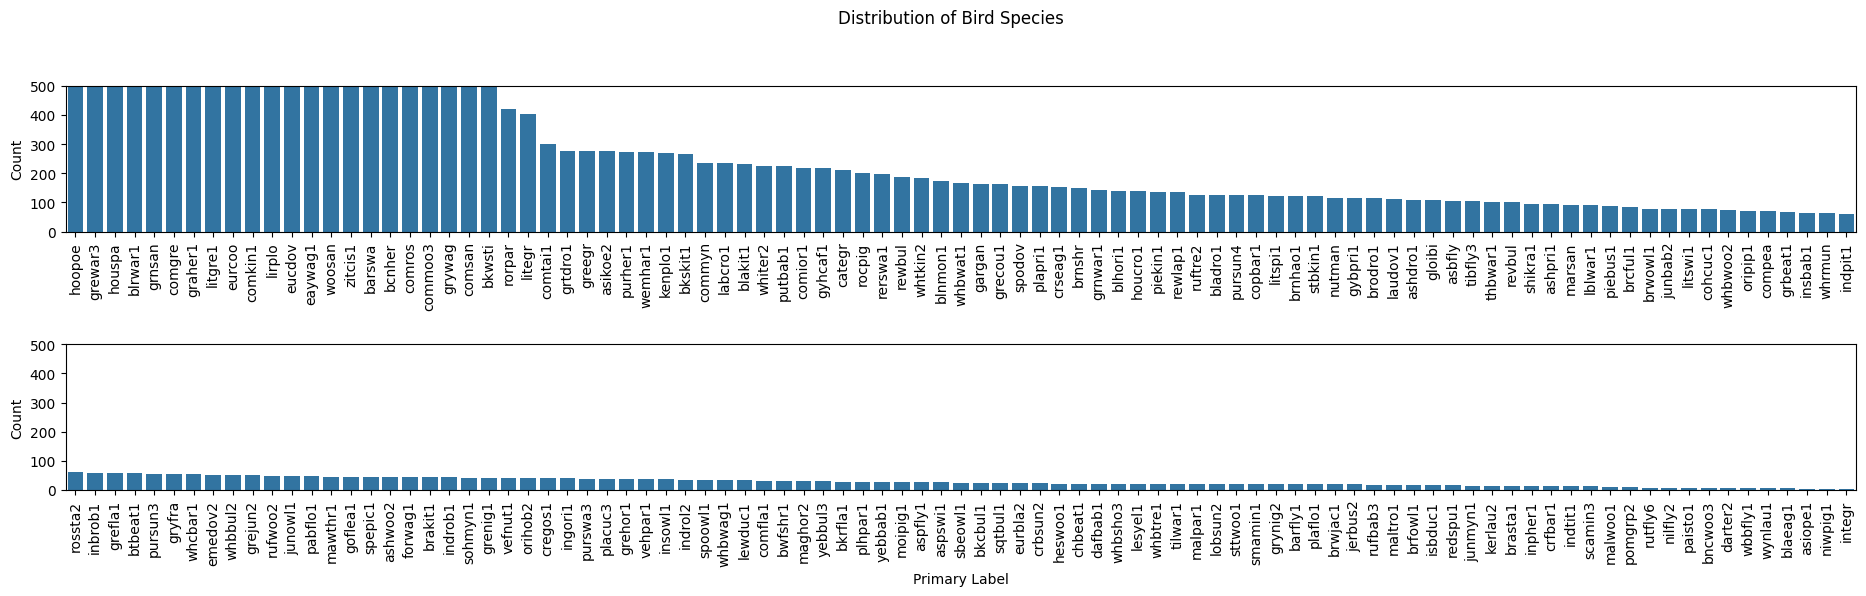

In [ ]:
bird_freq = train_meta['primary_label'].value_counts()

fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (20, 6), sharey = True)
fig.tight_layout(pad = 6)

sns.barplot(x = bird_freq[0:91].index, y = bird_freq[0:91].values, ax = ax1)
ax1.set_xticklabels(bird_freq[0:91].index, rotation = 90)
ax1.set_ylim(0, 500)
ax1.set_xlabel('')
ax1.set_ylabel('Count')

sns.barplot(x = bird_freq[91:].index, y = bird_freq[91:].values, ax = ax2)
ax2.set_xticklabels(bird_freq[91:].index, rotation = 90)
ax2.set_ylim(0, 500)
ax2.set_xlabel('Primary Label')
ax2.set_ylabel('Count')

fig.suptitle('Distribution of Bird Species')

fig.show()

# Prints the total number of unique bird species
print('Total unique bird species: ', len(train_meta['primary_label'].unique()), '\n')

In [ ]:
# Plots the bird species according to their geographical location (latitude, longitude)
fig = px.scatter_mapbox(train_meta, lat = 'latitude', lon = 'longitude', color = 'primary_label', title = 'Geographical Distribution of Bird Species', zoom = 0, height = 600, width = 1000, mapbox_style = 'open-street-map')
fig.show()

In [ ]:
# plot for western ghat
# boundaries for the Western Ghats - as per Google search
lower_latitude = 8
upper_latitude = 22
lower_longitude = 73
upper_longitude = 79
filtered_data = train_meta[(train_meta['latitude'] >= lower_latitude) &
                           (train_meta['latitude'] <= upper_latitude) &
                           (train_meta['longitude'] >= lower_longitude) &
                           (train_meta['longitude'] <= upper_longitude)]

fig = px.scatter_mapbox(filtered_data, lat="latitude", lon="longitude", color="common_name",
                        zoom=5, center={"lat": (lower_latitude + upper_latitude) / 2, "lon": (lower_longitude + upper_longitude) / 2})
fig.update_layout( title="Distribution of Bird Species in the Western Ghats", plot_bgcolor=None, paper_bgcolor=None,
    title_font=dict(size=20, family="Lato, sans-serif", color='#E1B12D'),  font=dict(color='#E1B12D'),
    mapbox_style="carto-positron", margin=dict(t=50, r=50, b=50, l=50), hovermode='closest',
    showlegend=True, legend=dict(title='Bird Species'), legend_title_font=dict(color='#E1B12D'))
fig.show()

### eBird_Taxonomy_v2021

In [ ]:
# Load the train_metadata.csv file
eBird_Taxonomy = pd.read_csv(f'{BASE_PATH}/eBird_Taxonomy_v2021.csv')
eBird_Taxonomy.head()

,TAXON_ORDER,CATEGORY,SPECIES_CODE,PRIMARY_COM_NAME,SCI_NAME,ORDER1,FAMILY,SPECIES_GROUP,REPORT_AS
0,1,species,ostric2,Common Ostrich,Struthio camelus,Struthioniformes,Struthionidae (Ostriches),Ostriches,NaN
1,6,species,ostric3,Somali Ostrich,Struthio molybdophanes,Struthioniformes,Struthionidae (Ostriches),NaN,NaN
2,7,slash,y00934,Common/Somali Ostrich,Struthio camelus/molybdophanes,Struthioniformes,Struthionidae (Ostriches),NaN,NaN
3,8,species,grerhe1,Greater Rhea,Rhea americana,Rheiformes,Rheidae (Rheas),Rheas,NaN
4,14,species,lesrhe2,Lesser Rhea,Rhea pennata,Rheiformes,Rheidae (Rheas),NaN,NaN


In [ ]:
summary(eBird_Taxonomy).style.set_caption("**Summary of the Train Data**").\
background_gradient(cmap='Pastel2_r', axis=0). \
set_properties(**{'border': '1.3px dotted', 'color': '', 'caption-side': 'left'})

,data type,#missing,Duplicate,#unique,min,max,avg,std dev,top value,Freq
TAXON_ORDER,int64,0,0,16753,1.000000,35000.000000,16654.013013,10185.185315,nan,nan
CATEGORY,object,0,0,8,nan,nan,nan,nan,species,10824
SPECIES_CODE,object,0,0,16753,nan,nan,nan,nan,bird1,1
PRIMARY_COM_NAME,object,0,0,16753,nan,nan,nan,nan,bird sp.,1
SCI_NAME,object,0,0,16753,nan,nan,nan,nan,Aves sp.,1
ORDER1,object,2,0,41,nan,nan,nan,nan,Passeriformes,9935
FAMILY,object,13,0,249,nan,nan,nan,nan,Tyrannidae (Tyrant Flycatchers),658
SPECIES_GROUP,object,16537,0,216,nan,nan,nan,nan,Longspurs and Snow Buntings,1
REPORT_AS,object,12877,0,1400,nan,nan,nan,nan,islthr1,39


In [ ]:
def cat_feature_dist(data, feature):
    # Count unique values
    value_counts = data[feature].value_counts().sort_values(ascending=False)

    # Plot
    fig = px.bar(y=value_counts.index[::-1], x=value_counts[::-1], orientation='h')
    fig.update_yaxes(title='')
    fig.update_xaxes(title_text='Count')
    fig.update_layout(
        showlegend=False,
        plot_bgcolor='#1C1D20',
        paper_bgcolor='#1C1D20',
        font=dict(size=16, color='#E1B12D'),
        title_font=dict(size=20, color='#222'),
        barmode='group',
        title=f"Distribution of '{feature}'"
    )
    fig.show()
    print(f"\nTotal unique values in '{feature}'are:",data[feature].nunique())
    print("\nTop 5 values:", value_counts.head())
    print("\nBottom 5 values:", value_counts.tail())

In [ ]:
cat_feature_dist(eBird_Taxonomy,'FAMILY')


Total unique values in 'FAMILY'are: 249

Top 5 values: FAMILY
Tyrannidae (Tyrant Flycatchers)             658
Thraupidae (Tanagers and Allies)            544
Trochilidae (Hummingbirds)                  533
Muscicapidae (Old World Flycatchers)        529
Furnariidae (Ovenbirds and Woodcreepers)    495
Name: count, dtype: int64

Bottom 5 values: FAMILY
Dromadidae (Crab-Plover)                1
Panuridae (Bearded Reedling)            1
Nesospingidae (Puerto Rican Tanager)    1
Peucedramidae (Olive Warbler)           1
Pedionomidae (Plains-wanderer)          1
Name: count, dtype: int64


## 전처리

In [ ]:
def load_audio(filepath):
    audio, sr = librosa.load(filepath)   # 음성 데이터, sample rate 로드
    return audio, sr



def get_spectrogram(audio):
    spec = librosa.feature.melspectrogram(y=audio,
                                   sr=CFG.sample_rate,
                                   n_mels=256,
                                   n_fft=2048,  # window size..
                                   hop_length=512,
                                   fmax=CFG.fmax,
                                   fmin=CFG.fmin,
                                   )
    spec = librosa.power_to_db(spec, ref=1.0)
    min_ = spec.min()
    max_ = spec.max()
    if max_ != min_:
        spec = (spec - min_)/(max_ - min_)
    return spec

def display_audio(row):
    # Caption for viz
    caption = f'Id: {row.filename} | Name: {row.common_name} | Sci.Name: {row.scientific_name} | Rating: {row.rating}'
    # Read audio file
    audio, sr = load_audio(row.filepath)
    # Keep fixed length audio
    audio = audio[:CFG.audio_len]
    # Spectrogram from audio
    spec = get_spectrogram(audio)
    # Display audio
    print("# Audio:")
    display(ipd.Audio(audio, rate=CFG.sample_rate))
    print('# Visualization:')
    fig, ax = plt.subplots(2, 1, figsize=(12, 2*3), sharex=True, tight_layout=True)
    fig.suptitle(caption)
    # Waveplot
    lid.waveshow(audio,
                 sr=CFG.sample_rate,
                 ax=ax[0],
                 color= cmap(0.1))
    # Specplot
    lid.specshow(spec,
                 sr = CFG.sample_rate,
                 hop_length=512,
                 n_fft=2048,
                 fmin=CFG.fmin,
                 fmax=CFG.fmax,
                 x_axis = 'time',
                 y_axis = 'mel',
                 cmap = 'coolwarm',
                 ax=ax[1])
    ax[0].set_xlabel('');
    fig.show()

# Audio:


# Visualization:


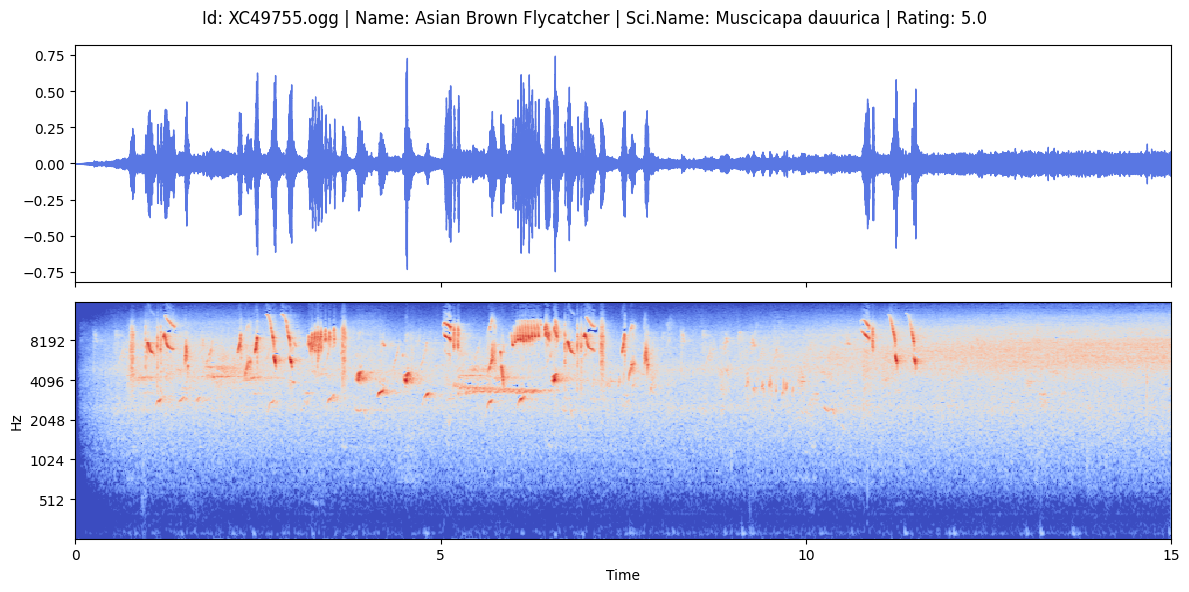

In [ ]:
row = train_meta.iloc[35]

# Display audio sample
display_audio(row)

In [ ]:
# Import required packages
from sklearn.model_selection import train_test_split

train_df, valid_df = train_test_split(train_meta, test_size=0.2)

print(f"Num Train: {len(train_df)} | Num Valid: {len(valid_df)}")

Num Train: 19567 | Num Valid: 4892


In [ ]:
# Decodes Audio
def build_decoder(with_labels=True, dim=1024):
    def get_audio(filepath):
        file_bytes = tf.io.read_file(filepath)
        audio = tfio.audio.decode_vorbis(file_bytes)  # decode .ogg file
        audio = tf.cast(audio, tf.float32)
        if tf.shape(audio)[1] > 1:  # stereo -> mono
            audio = audio[..., 0:1]
        audio = tf.squeeze(audio, axis=-1)
        return audio

    def crop_or_pad(audio, target_len, pad_mode="constant"):
        audio_len = tf.shape(audio)[0]
        diff_len = abs(
            target_len - audio_len
        )  # find difference between target and audio length
        if audio_len < target_len:  # do padding if audio length is shorter
            pad1 = tf.random.uniform([], maxval=diff_len, dtype=tf.int32)
            pad2 = diff_len - pad1
            audio = tf.pad(audio, paddings=[[pad1, pad2]], mode=pad_mode)
        elif audio_len > target_len:  # do cropping if audio length is larger
            idx = tf.random.uniform([], maxval=diff_len, dtype=tf.int32)
            audio = audio[idx : (idx + target_len)]
        return tf.reshape(audio, [target_len])

    def apply_preproc(spec):
        # Standardize
        mean = tf.math.reduce_mean(spec)
        std = tf.math.reduce_std(spec)
        spec = tf.where(tf.math.equal(std, 0), spec - mean, (spec - mean) / std)

        # Normalize using Min-Max
        min_val = tf.math.reduce_min(spec)
        max_val = tf.math.reduce_max(spec)
        spec = tf.where(
            tf.math.equal(max_val - min_val, 0),
            spec - min_val,
            (spec - min_val) / (max_val - min_val),
        )
        return spec

    def get_target(target):
        target = tf.reshape(target, [1])
        target = tf.cast(tf.one_hot(target, CFG.num_classes), tf.float32)
        target = tf.reshape(target, [CFG.num_classes])
        return target

    def decode(path):
        # Load audio file
        audio = get_audio(path)
        # Crop or pad audio to keep a fixed length
        audio = crop_or_pad(audio, dim)
        # Audio to Spectrogram
        spec = keras.layers.MelSpectrogram(
            num_mel_bins=CFG.img_size[0],
            fft_length=CFG.nfft,
            sequence_stride=CFG.hop_length,
            sampling_rate=CFG.sample_rate,
        )(audio)
        # Apply normalization and standardization
        spec = apply_preproc(spec)
        # Spectrogram to 3 channel image (for imagenet)
        spec = tf.tile(spec[..., None], [1, 1, 3])
        spec = tf.reshape(spec, [*CFG.img_size, 3])
        return spec

    def decode_with_labels(path, label):
        label = get_target(label)
        return decode(path), label

    return decode_with_labels if with_labels else decode

In [ ]:
def build_augmenter():
    augmenters = [
        keras_cv.layers.MixUp(alpha=0.4),
        keras_cv.layers.RandomCutout(height_factor=(1.0, 1.0),
                                     width_factor=(0.06, 0.12)), # time-masking
        keras_cv.layers.RandomCutout(height_factor=(0.06, 0.1),
                                     width_factor=(1.0, 1.0)), # freq-masking
    ]

    def augment(img, label):
        data = {"images":img, "labels":label}
        for augmenter in augmenters:
            if tf.random.uniform([]) < 0.35:
                data = augmenter(data, training=True)
        return data["images"], data["labels"]

    return augment

In [ ]:
def build_dataset(paths, labels=None, batch_size=32,
                  decode_fn=None, augment_fn=None, cache=True,
                  augment=False, shuffle=2048):

    if decode_fn is None:
        decode_fn = build_decoder(labels is not None, dim=CFG.audio_len)

    if augment_fn is None:
        augment_fn = build_augmenter()

    AUTO = tf.data.experimental.AUTOTUNE
    slices = (paths,) if labels is None else (paths, labels)
    ds = tf.data.Dataset.from_tensor_slices(slices)
    ds = ds.map(decode_fn, num_parallel_calls=AUTO)
    ds = ds.cache() if cache else ds
    if shuffle:
        opt = tf.data.Options()
        ds = ds.shuffle(shuffle, seed=CFG.seed)
        opt.experimental_deterministic = False
        ds = ds.with_options(opt)
    ds = ds.batch(batch_size, drop_remainder=True)
    ds = ds.map(augment_fn, num_parallel_calls=AUTO) if augment else ds
    ds = ds.prefetch(AUTO)
    return ds

In [ ]:
import tensorflow as tf
import tensorflow_io as tfio

# Train
train_paths = train_df.filepath.values
train_labels = train_df.target.values
train_ds = build_dataset(train_paths, train_labels, batch_size=CFG.batch_size,
                         shuffle=True, augment=CFG.augment)

# Valid
valid_paths = valid_df.filepath.values
valid_labels = valid_df.target.values
valid_ds = build_dataset(valid_paths, valid_labels, batch_size=CFG.batch_size,
                         shuffle=False, augment=False)

In [ ]:
def plot_batch(batch, row=3, col=3, label2name=None,):
    """Plot one batch data"""
    if isinstance(batch, tuple) or isinstance(batch, list):
        specs, tars = batch
    else:
        specs = batch
        tars = None
    plt.figure(figsize=(col*5, row*3))
    for idx in range(row*col):
        ax = plt.subplot(row, col, idx+1)
        lid.specshow(np.array(specs[idx, ..., 0]),
                     n_fft=CFG.nfft,
                     hop_length=CFG.hop_length,
                     sr=CFG.sample_rate,
                     x_axis='time',
                     y_axis='mel',
                     cmap='coolwarm')
        if tars is not None:
            label = tars[idx].numpy().argmax()
            name = label2name[label]
            plt.title(name)
    plt.tight_layout()
    plt.show()

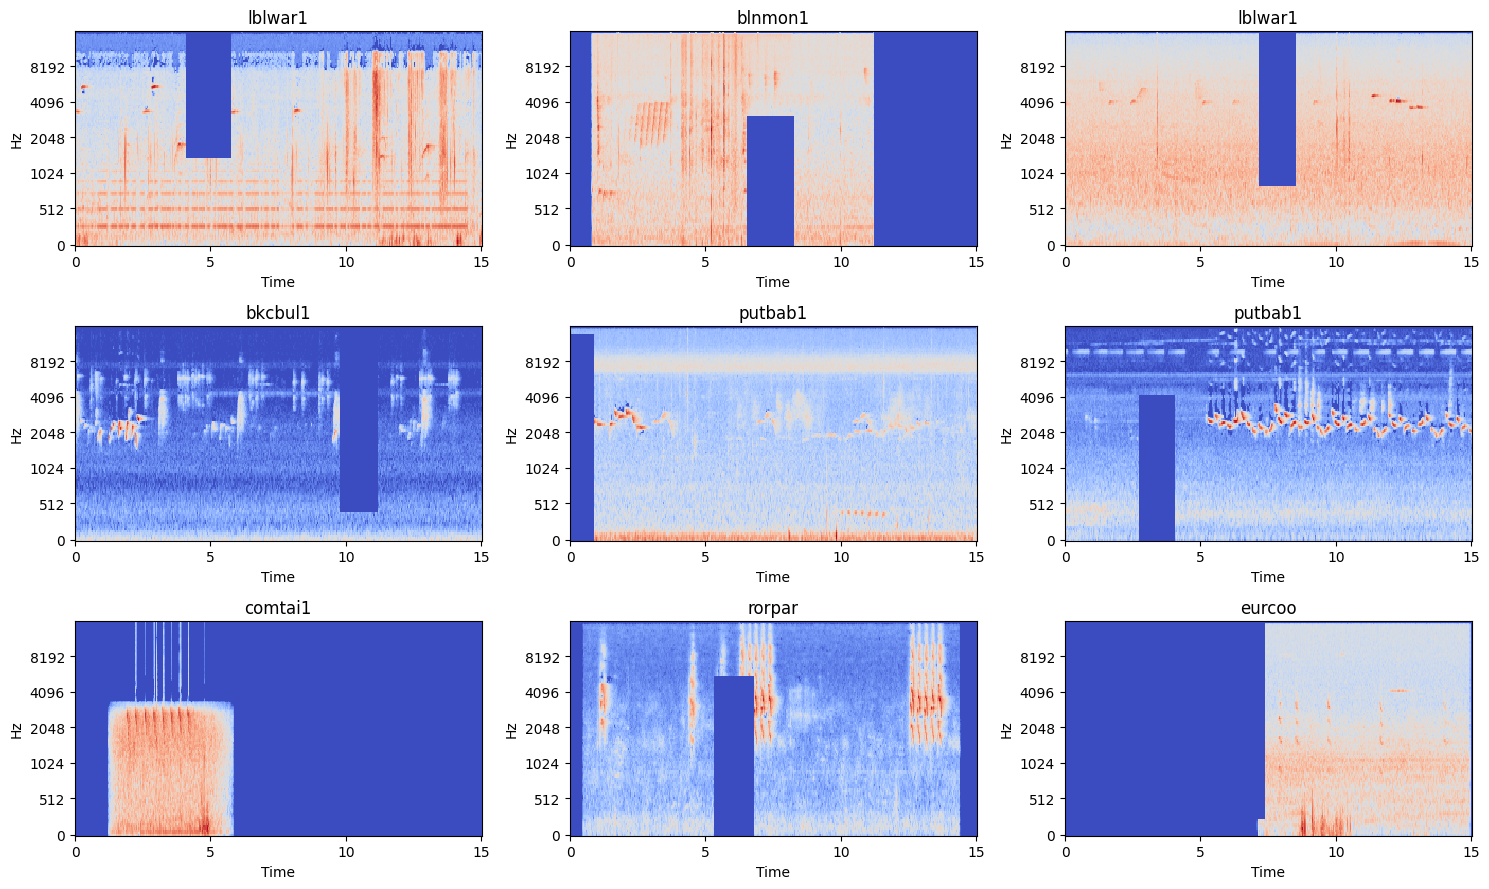

In [ ]:
sample_ds = train_ds.take(50)
batch = next(iter(sample_ds))
plot_batch(batch, label2name=CFG.label2name)